# Còdigo com  dados melhorados


--- RESUMO DA EXECUÇÃO ---
Baseline FCFS fitness: 0.338304
FCFS summary: {'mean_distance_km': 22.63702209302658, 'assigned_count': 60}
Baseline Greedy fitness: 0.415386
Greedy summary: {'mean_distance_km': 4.834234967349063, 'assigned_count': 60}

GA with repair fitness: 0.428201
GA summary: {'mean_distance_km': 4.6551742659847895, 'assigned_count': 60}

=== RELATÓRIO DE DIAGNÓSTICOS ===

--- FCFS DIAGNÓSTICOS ---
fitness: 0.338304
total_cost: 1.95592
exp_noshows: 9.456227
expected_noshows_sum: 9.456227
travel_cost: 45.274044
wait_cost: 24.8
slot_penalty: 0

--- GREEDY DIAGNÓSTICOS ---
fitness: 0.415386
total_cost: 1.407402
exp_noshows: 8.541797
expected_noshows_sum: 8.541797
travel_cost: 9.66847
wait_cost: 32.066667
slot_penalty: 0

--- GA DIAGNÓSTICOS ---
fitness: 0.428201
total_cost: 1.335349
exp_noshows: 8.555455
expected_noshows_sum: 8.555455
travel_cost: 9.310349
wait_cost: 28.033333
slot_penalty: 0

=== First 12 GA assignments ===
 patient   origin      spec  slot     dest  dis

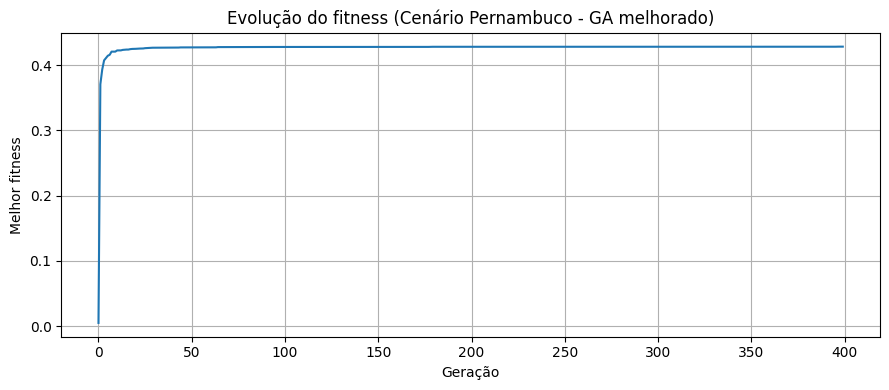

In [ ]:
# Otimização e Transparência na Distribuição de Pacientes nas UPAe (PE)
# Versão Final com Relatório Formatado

import random, math
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

random.seed(42)

# ==========================================
# 1. FUNÇÕES AUXILIARES E GEOGRAFIA
# ==========================================

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    phi1 = math.radians(lat1); phi2 = math.radians(lat2)
    dphi = math.radians(lat2 - lat1); dl = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*(math.sin(dl/2)**2)
    return 2 * R * math.atan2(math.sqrt(a), math.sqrt(1-a))

def clamp(x, a=0.0, b=0.95):
    return max(a, min(b, x))

# ==========================================
# 2. GERADOR DE DADOS (CENÁRIO PE)
# ==========================================

def generate_pe_data(n_patients=60, n_slots=80):
    CITIES = {
        'Recife':   {'coords': (-8.05428, -34.8813), 'demand_weight': 0.3},
        'Jaboatao': {'coords': (-8.1765, -35.0326),  'demand_weight': 0.4},
        'Cabo':     {'coords': (-8.2839, -35.0321),  'demand_weight': 0.15},
        'Igarassu': {'coords': (-7.8306, -34.9085),  'demand_weight': 0.15}
    }
    
    SPECIALTIES = ('cardio', 'endo', 'ortopedia')
    patients = []
    slots = []
    start_date = datetime.now() + timedelta(days=1)
    
    city_names = list(CITIES.keys())
    city_weights = [CITIES[c]['demand_weight'] for c in city_names]

    # Gerar Pacientes
    for i in range(n_patients):
        city = random.choices(city_names, weights=city_weights, k=1)[0]
        base_lat, base_lon = CITIES[city]['coords']
        lat = base_lat + random.uniform(-0.03, 0.03)
        lon = base_lon + random.uniform(-0.03, 0.03)
        
        patients.append({
            'id': i, 
            'city_origin': city,
            'lat': lat, 
            'lon': lon, 
            'specialty': random.choice(SPECIALTIES)
        })

    # Gerar Vagas
    for s in range(n_slots):
        city = random.choice(city_names) 
        base_lat, base_lon = CITIES[city]['coords']
        lat = base_lat + random.uniform(-0.02, 0.02)
        lon = base_lon + random.uniform(-0.02, 0.02)
        
        if city in ['Recife', 'Jaboatao']:
            transport_score = random.uniform(0.7, 1.0)
        else:
            transport_score = random.uniform(0.2, 0.6)
            
        slots.append({
            'slot_id': s, 
            'city_unit': city,
            'lat': lat, 
            'lon': lon, 
            'specialty': random.choice(SPECIALTIES), 
            'date': start_date + timedelta(days=random.randint(0, 30)), 
            'transport_score': transport_score
        })
        
    base_no_show_by_specialty = {'cardio': 0.05, 'endo': 0.40, 'ortopedia': 0.25}
    return patients, slots, base_no_show_by_specialty

patients, slots, base_ns = generate_pe_data()

# ==========================================
# 3. LÓGICA DO GA (ATUALIZADA)
# ==========================================

# Pesos conservadores + normalização
ALPHA = 5.0   # peso do no-show médio
BETA  = 1.0   # peso do deslocamento médio
GAMMA = 1.0   # peso da espera média
ZETA  = 1000.0  # penalidade normalizada (por paciente), ainda forte
C_MISS = 1.0

DIST_REF = 30.0
WREF = 30.0
LAMBDA_D = 0.02
LAMBDA_T = 0.5

def compute_p_noshow(patient, slot, base_no_show):
    dist = haversine(patient['lat'], patient['lon'], slot['lat'], slot['lon'])
    transport_score = slot.get('transport_score', 0.5)
    p = base_no_show * (1 + LAMBDA_D * (dist / DIST_REF)) * (1 - LAMBDA_T * transport_score)
    return clamp(p, 0.0, 0.95), dist

def fitness_of_chromosome(chromosome, patients, slots, base_no_show_by_specialty):
    now = datetime.now()
    slot_map = {s['slot_id']: s for s in slots}
    N = len(patients)
    
    # mapeamento slot -> pacientes
    slot_assignments = defaultdict(list)
    for i, slot_id in enumerate(chromosome):
        if slot_id is None or slot_id == -1:
            continue
        slot_assignments[slot_id].append(i)
    
    # conflitos, invalids, não alocados
    conflicts = sum(max(0, len(lst)-1) for lst in slot_assignments.values())
    invalids = 0
    for slot_id, lst in slot_assignments.items():
        slot = slot_map.get(slot_id)
        for pi in lst:
            pat = patients[pi]
            if slot is None or slot['specialty'] != pat['specialty']:
                invalids += 1
    num_unallocated = sum(1 for s in chromosome if s == -1 or s is None)
    SlotConstraintPenalty = conflicts + invalids + num_unallocated
    
    ExpNoShowCost = 0.0
    TravelCost = 0.0
    WaitCost = 0.0
    expected_noshows_sum = 0.0
    
    for i, slot_id in enumerate(chromosome):
        pat = patients[i]
        if slot_id in (-1, None):
            continue
        slot = slot_map.get(slot_id)
        if slot is None:
            continue
        
        base = base_no_show_by_specialty.get(pat['specialty'], 0.3)
        p_ns, dist = compute_p_noshow(pat, slot, base)
        
        ExpNoShowCost += p_ns * C_MISS
        expected_noshows_sum += p_ns
        TravelCost += (dist / DIST_REF)
        days_wait = max(0, (slot['date'] - now).days)
        WaitCost += (days_wait / WREF)
    
    # normalização por paciente
    norm_ns   = ExpNoShowCost / N
    norm_trav = TravelCost / N
    norm_wait = WaitCost / N
    norm_pen  = SlotConstraintPenalty / N
    
    total_cost = (
        ALPHA * norm_ns +
        BETA  * norm_trav +
        GAMMA * norm_wait +
        ZETA  * norm_pen
    )
    
    fitness = 1.0 / (1.0 + total_cost)
    
    diagnostics = {'fitness': fitness, 'total_cost': total_cost, 'exp_noshows': ExpNoShowCost, 'expected_noshows_sum': expected_noshows_sum, 'travel_cost': TravelCost,
                   'wait_cost': WaitCost, 'slot_penalty': SlotConstraintPenalty}
    return fitness, diagnostics

# === Baselines (mantidos) ===

def baseline_fcfs(patients, slots):
    slots_by_spec = defaultdict(list)
    for s in sorted(slots, key=lambda x: x['date']):
        slots_by_spec[s['specialty']].append(s['slot_id'])
    used = set()
    chrom = [-1]*len(patients)
    for i, pat in enumerate(patients):
        avail = slots_by_spec.get(pat['specialty'], [])
        assigned = False
        for sid in avail:
            if sid not in used:
                chrom[i] = sid
                used.add(sid)
                assigned = True
                break
        if not assigned:
            chrom[i] = -1
    return chrom

def baseline_greedy_proximity(patients, slots):
    free_slots = {s['slot_id']: s for s in slots}
    chrom = [-1]*len(patients)
    for i, pat in enumerate(patients):
        best_sid = None; best_dist = float('inf')
        for sid, s in list(free_slots.items()):
            if s['specialty'] != pat['specialty']:
                continue
            dist = haversine(pat['lat'], pat['lon'], s['lat'], s['lon'])
            if dist < best_dist:
                best_dist = dist; best_sid = sid
        if best_sid is not None:
            chrom[i] = best_sid
            free_slots.pop(best_sid, None)
        else:
            chrom[i] = -1
    return chrom

# === Funções auxiliares para GA ===

def get_compatible_slots_for_patient(patient, slots):
    return [s['slot_id'] for s in slots if s['specialty'] == patient['specialty']]

def init_population(pop_size, patients, slots):
    compat_map = [get_compatible_slots_for_patient(p, slots) for p in patients]
    population = []
    for _ in range(pop_size):
        chrom = []
        for compat in compat_map:
            if not compat:
                chrom.append(-1)
            else:
                chrom.append(random.choice(compat))
        population.append(chrom)
    return population

def tournament_selection(population, fitnesses, k=2):
    selected = random.sample(range(len(population)), k)
    best = max(selected, key=lambda idx: fitnesses[idx])
    return population[best]

def uniform_crossover(parent1, parent2, crossover_rate=0.9):
    if random.random() > crossover_rate:
        return parent1.copy(), parent2.copy()
    n = len(parent1)
    child1 = [None]*n; child2 = [None]*n
    for i in range(n):
        if random.random() < 0.5:
            child1[i] = parent1[i]; child2[i] = parent2[i]
        else:
            child1[i] = parent2[i]; child2[i] = parent1[i]
    return child1, child2

def mutation(chromosome, patients, slots, mutation_rate):
    n = len(chromosome)
    if random.random() < mutation_rate:
        op = random.random()
        if op < 0.4:
            # swap simples
            i, j = random.sample(range(n), 2)
            chromosome[i], chromosome[j] = chromosome[j], chromosome[i]
        elif op < 0.8:
            # reatribuir paciente para outro slot compatível (ou -1)
            i = random.randrange(n)
            compat = get_compatible_slots_for_patient(patients[i], slots)
            if compat:
                chromosome[i] = random.choice(compat + [-1])
        else:
            # shuffle de um pequeno bloco
            start = random.randint(0, n-3)
            end = min(n, start + random.randint(2, 5))
            subset = chromosome[start:end]
            random.shuffle(subset)
            chromosome[start:end] = subset
    return chromosome

def repair_chromosome(chromosome, patients, slots):
    """
    Reparo mais cuidadoso:
    - Remove slots inválidos
    - Resolve conflitos mantendo paciente mais próximo
    - Garante especialidade compatível
    - Realoca pacientes sem vaga para slots compatíveis livres mais próximos
    """
    slot_map = {s['slot_id']: s for s in slots}
    rev = defaultdict(list)
    for i, sid in enumerate(chromosome):
        if sid is None or sid == -1:
            continue
        rev[sid].append(i)
    
    free_slots = set(s['slot_id'] for s in slots)
    
    # 1) remover slots inexistentes
    for sid, lst in list(rev.items()):
        if sid not in slot_map:
            for i in lst:
                chromosome[i] = -1
            rev.pop(sid, None)
    
    # 2) conflitos por slot: fica o paciente mais próximo com especialidade compatível
    for sid, lst in rev.items():
        slot = slot_map[sid]
        valid_list = [i for i in lst if patients[i]['specialty'] == slot['specialty']]
        invalid_list = [i for i in lst if patients[i]['specialty'] != slot['specialty']]
        
        for i in invalid_list:
            chromosome[i] = -1
        
        if not valid_list:
            continue
        
        dists = [
            (i, haversine(patients[i]['lat'], patients[i]['lon'], slot['lat'], slot['lon']))
            for i in valid_list
        ]
        dists.sort(key=lambda x: x[1])
        
        # mantém só o mais próximo
        for i, _ in dists[1:]:
            chromosome[i] = -1
        
        free_slots.discard(sid)
    
    # 3) garantir compatibilidade restante
    for i, sid in enumerate(chromosome):
        if sid is None or sid == -1:
            continue
        slot = slot_map.get(sid)
        if slot is None or slot['specialty'] != patients[i]['specialty']:
            chromosome[i] = -1
        else:
            if sid in free_slots:
                free_slots.discard(sid)
    
    # 4) realocar pacientes sem vaga para slots livres compatíveis mais próximos
    free_slot_list = list(free_slots)
    for i, sid in enumerate(chromosome):
        if sid not in (-1, None):
            continue
        compat_slots = [
            s for s in slots
            if s['specialty'] == patients[i]['specialty'] and s['slot_id'] in free_slot_list
        ]
        if not compat_slots:
            chromosome[i] = -1
            continue
        best = min(
            compat_slots,
            key=lambda s: haversine(patients[i]['lat'], patients[i]['lon'], s['lat'], s['lon'])
        )
        chromosome[i] = best['slot_id']
        free_slot_list.remove(best['slot_id'])
    return chromosome

def run_ga_with_repair(patients, slots, base_ns, pop_size=120, generations=400, crossover_rate=0.9, mutation_rate=0.2, elitism=0.1):
    population = init_population(pop_size, patients, slots)
    best_history = []
    for gen in range(generations):
        fitnesses = [fitness_of_chromosome(ch, patients, slots, base_ns)[0] for ch in population]
        best_idx = max(range(len(population)), key=lambda i: fitnesses[i])
        best_history.append((gen, fitnesses[best_idx]))
        new_pop = []
        num_elite = max(1, int(elitism * pop_size))
        elite_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)[:num_elite]
        for i in elite_indices: new_pop.append(population[i].copy())
        while len(new_pop) < pop_size:
            parent1 = tournament_selection(population, fitnesses, k=3)
            parent2 = tournament_selection(population, fitnesses, k=3)
            child1, child2 = uniform_crossover(parent1, parent2, crossover_rate=crossover_rate)
            child1 = mutation(child1, patients, slots, mutation_rate=mutation_rate)
            child2 = mutation(child2, patients, slots, mutation_rate=mutation_rate)
            child1 = repair_chromosome(child1, patients, slots)
            child2 = repair_chromosome(child2, patients, slots)
            new_pop.append(child1)
            if len(new_pop) < pop_size: new_pop.append(child2)
        population = new_pop
    fitnesses = [fitness_of_chromosome(ch, patients, slots, base_ns)[0] for ch in population]
    best_idx = max(range(len(population)), key=lambda i: fitnesses[i])
    best_chrom = population[best_idx]
    best_fitness, best_diag = fitness_of_chromosome(best_chrom, patients, slots, base_ns)
    return {'best_chromosome': best_chrom, 'best_fitness': best_fitness, 'best_diag': best_diag, 'history': best_history}
# ==========================================
# 4. EXECUÇÃO
# ==========================================

chrom_fcfs = baseline_fcfs(patients, slots)
f_fcfs, d_fcfs = fitness_of_chromosome(chrom_fcfs, patients, slots, base_ns)

chrom_greedy = baseline_greedy_proximity(patients, slots)
f_greedy, d_greedy = fitness_of_chromosome(chrom_greedy, patients, slots, base_ns)

res_ga = run_ga_with_repair(
    patients, slots, base_ns, pop_size=120, generations=400, crossover_rate=0.7, mutation_rate =0.3, elitism=0.15
)

f_ga = res_ga['best_fitness']
ga_chrom = res_ga['best_chromosome']
d_ga = res_ga['best_diag']
history = res_ga['history']
gens = [g for g,f in history]
fitness_vals = [f for g,f in history]

def summarize(chrom):
    assigned = [c for c in chrom if c is not None and c != -1]
    slot_map = {s['slot_id']: s for s in slots}
    dists = []
    for i, sid in enumerate(chrom):
        if sid is None or sid == -1: continue
        p = patients[i]; s = slot_map.get(sid)
        if s: dists.append(haversine(p['lat'], p['lon'], s['lat'], s['lon']))
    return {'mean_distance_km': (sum(dists)/len(dists)) if dists else None, 'assigned_count': len(assigned)}

print("\n--- RESUMO DA EXECUÇÃO ---")
print("Baseline FCFS fitness:", round(f_fcfs,6))
print("FCFS summary:", summarize(chrom_fcfs))
print("Baseline Greedy fitness:", round(f_greedy,6))
print("Greedy summary:", summarize(chrom_greedy))
print("\nGA with repair fitness:", round(f_ga,6))
print("GA summary:", summarize(ga_chrom))

# --- RELATÓRIO FORMATADO ---
result_compare = {
    'fcfs': { 'diag': d_fcfs},
    'greedy': {'diag': d_greedy},
    'ga': {'diag': d_ga}
}

print("\n=== RELATÓRIO DE DIAGNÓSTICOS ===")
for method, res in result_compare.items():
    diag = res['diag']
    print(f"\n--- {method.upper()} DIAGNÓSTICOS ---")
    for k, v in diag.items():
        if isinstance(v, float):
            print(f"{k}: {round(v,6)}")
        else:
            print(f"{k}: {v}")

# --- ASSIGNMENTS ---
slot_map = {s['slot_id']: s for s in slots}
assignments = []
for i, sid in enumerate(ga_chrom):
    p = patients[i]
    if sid is None or sid == -1:
        assignments.append({'patient': i, 'origin': p['city_origin'], 'spec': p['specialty'], 'slot': None, 'dest': 'N/A', 'dist_km': None})
        continue
    s = slot_map.get(sid)
    dist = haversine(p['lat'], p['lon'], s['lat'], s['lon'])
    assignments.append({
        'patient': i, 
        'origin': p['city_origin'],
        'spec': p['specialty'], 
        'slot': sid, 
        'dest': s['city_unit'],
        'dist_km': round(dist,2), 
        'slot_date': s['date'].strftime("%Y-%m-%d")
    })

df_assign = pd.DataFrame(assignments)
print("\n=== First 12 GA assignments ===")
print(df_assign.head(12).to_string(index=False))

print("\n=== Exemplos de Redirecionamento (IA Responsável) ===")
diff_city = df_assign[df_assign['origin'] != df_assign['dest']].head(5)
if not diff_city.empty:
    print(diff_city[['origin', 'dest', 'spec', 'dist_km', 'slot_date']].to_string(index=False))
else:
    print("Nenhum redirecionamento entre cidades encontrado.")

plt.figure(figsize=(9,4))
plt.plot(gens, fitness_vals)
plt.title("Evolução do fitness (Cenário Pernambuco - GA melhorado)")
plt.xlabel("Geração")
plt.ylabel("Melhor fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


código com Deap

In [1]:
import random
import numpy as np
import math
from deap import base, creator, tools, algorithms

# ==========================================
# 1. MOCK DATA GENERATOR (Gerador de Dados Fictícios)
# ==========================================
# Como você não tem base de dados, vamos criar um cenário:
# Cidades: Jaboatão (Origem), Cabo, Igarassu, Recife.

CIDADES = {
    "Jaboatao": {"coords": (0, 0), "pacientes": 50}, # Origem principal
    "Recife":   {"coords": (10, 5), "upas": 2},      # Perto
    "Cabo":     {"coords": (15, -5), "upas": 1},     # Médio
    "Igarassu": {"coords": (40, 10), "upas": 1}      # Longe
}

ESPECIALIDADES = ["Cardiologia", "Ortopedia", "Dermatologia"]

class Paciente:
    def __init__(self, id, cidade_origem, coords_origem, especialidade, urgencia):
        self.id = id
        self.cidade = cidade_origem
        self.coords = coords_origem
        self.especialidade = especialidade
        self.urgencia = urgencia # 1 a 5 (5 é mais urgente)
        self.data_solicitacao = 0 # Dia 0

class VagaUPAe:
    def __init__(self, id_vaga, id_unidade, cidade_unidade, coords_unidade, especialidade, data_vaga):
        self.id = id_vaga
        self.id_unidade = id_unidade
        self.cidade = cidade_unidade
        self.coords = coords_unidade
        self.especialidade = especialidade
        self.data_vaga = data_vaga # Dia do ano (ex: dia 2, dia 5)

def gerar_cenario():
    pacientes = []
    vagas = []
    
    # Gerar Pacientes (maioria de Jaboatão precisando de Cardio)
    p_id = 0
    for _ in range(30): # 30 Pacientes
        esp = random.choice(ESPECIALIDADES)
        pacientes.append(Paciente(p_id, "Jaboatao", CIDADES["Jaboatao"]["coords"], esp, random.randint(1,5)))
        p_id += 1
        
    # Gerar Vagas nas UPAes
    v_id = 0
    # Recife tem muitas vagas e perto
    for _ in range(10): 
        vagas.append(VagaUPAe(v_id, "UPA_RECIFE", "Recife", CIDADES["Recife"]["coords"], "Cardiologia", random.randint(1, 10)))
        v_id += 1
    # Cabo tem vagas médias mas demora um pouco (2-3 dias)
    for _ in range(10):
        vagas.append(VagaUPAe(v_id, "UPA_CABO", "Cabo", CIDADES["Cabo"]["coords"], "Cardiologia", random.randint(2, 5)))
        v_id += 1
    # Igarassu tem vagas imediatas (dia 1) mas é longe
    for _ in range(10):
        vagas.append(VagaUPAe(v_id, "UPA_IGARASSU", "Igarassu", CIDADES["Igarassu"]["coords"], "Cardiologia", 1))
        v_id += 1
        
    # Adicionar outras especialidades aleatórias para testar restrições
    for _ in range(20):
         vagas.append(VagaUPAe(v_id, "UPA_GENERICA", "Recife", CIDADES["Recife"]["coords"], "Ortopedia", random.randint(1, 20)))
         v_id += 1

    return pacientes, vagas

# Instanciar dados
PACIENTES, VAGAS = gerar_cenario()
NUM_PACIENTES = len(PACIENTES)
NUM_VAGAS = len(VAGAS)

# ==========================================
# 2. CONFIGURAÇÃO DO DEAP (GA)
# ==========================================

# Definimos o objetivo: Minimizar Distância E Minimizar Tempo de Espera
# weights=(-1.0, -1.0) significa minimizar ambos os objetivos
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()

# Atributo do indivíduo: Para cada paciente, um índice de vaga (0 a NUM_VAGAS-1)
# Se o gene for -1, significa "sem vaga" (fila de espera)
toolbox.register("attr_vaga", random.randint, -1, NUM_VAGAS - 1)

# Estrutura do indivíduo: Lista de tamanho NUM_PACIENTES
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_vaga, n=NUM_PACIENTES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# ==========================================
# 3. FUNÇÃO DE APTIDÃO (FITNESS) & RESTRIÇÕES
# ==========================================

def calcular_distancia(coords1, coords2):
    return math.sqrt((coords1[0] - coords2[0])**2 + (coords1[1] - coords2[1])**2)

def eval_alocacao(individual):
    total_distancia = 0
    total_tempo_espera = 0
    penalidade = 0
    
    # Dicionário para controlar capacidade das vagas (uma vaga só pode ser usada por 1 pessoa)
    vagas_usadas = {} 
    
    for i, id_vaga in enumerate(individual):
        paciente = PACIENTES[i]
        
        # Caso o paciente não seja alocado (gene -1)
        if id_vaga == -1:
            total_distancia += 1000 # Penalidade alta por não atender
            total_tempo_espera += 100 # Penalidade alta
            continue
            
        # Restrição de Índice válido
        if id_vaga < 0 or id_vaga >= NUM_VAGAS:
            penalidade += 10000
            continue

        vaga = VAGAS[id_vaga]
        
        # RESTRIÇÃO DURA 1: Especialidade deve bater
        if paciente.especialidade != vaga.especialidade:
            penalidade += 5000 # Penalidade severa
            
        # RESTRIÇÃO DURA 2: Vaga única (Capacidade)
        if id_vaga in vagas_usadas:
            penalidade += 5000 # Colisão de agendamento
        else:
            vagas_usadas[id_vaga] = True
            
        # CÁLCULO DOS OBJETIVOS
        if penalidade == 0:
            dist = calcular_distancia(paciente.coords, vaga.coords)
            tempo = vaga.data_vaga - paciente.data_solicitacao # Dias de espera
            
            total_distancia += dist
            total_tempo_espera += tempo

    # Retorna Distância Total e Tempo Total + Penalidades
    return total_distancia + penalidade, total_tempo_espera + penalidade

# Registrar operadores genéticos
toolbox.register("evaluate", eval_alocacao)
toolbox.register("mate", tools.cxTwoPoint) # Crossover de dois pontos
toolbox.register("mutate", tools.mutUniformInt, low=-1, up=NUM_VAGAS-1, indpb=0.1) # Mutação
toolbox.register("select", tools.selNSGA2) # Seleção NSGA-II (Ótimo para multi-objetivo)

# ==========================================
# 4. LOOP EVOLUTIVO E EXPLICABILIDADE
# ==========================================

def explicar_decisao(paciente, vaga):
    """Gera uma explicação em linguagem natural (Transparência/IA Responsável)"""
    dist = calcular_distancia(paciente.coords, vaga.coords)
    tempo = vaga.data_vaga
    
    msg = f"Paciente {paciente.id} ({paciente.cidade}) -> {vaga.cidade}."
    justificativa = ""
    
    if dist > 30 and tempo <= 1:
        justificativa = "Motivo: Priorizado atendimento imediato (1 dia), aceitando maior deslocamento."
    elif dist < 20 and tempo > 2:
        justificativa = "Motivo: Priorizado proximidade geográfica, aceitando espera moderada."
    else:
        justificativa = "Motivo: Melhor equilíbrio encontrado pelo algoritmo."
        
    return f"{msg} | Dist: {dist:.1f}km | Espera: {tempo} dias. \n   >> {justificativa}"

def main():
    random.seed(42)
    
    # Criar população inicial
    pop = toolbox.population(n=100)
    
    # Estatísticas
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min, axis=0)
    stats.register("avg", np.mean, axis=0)
    
    # Rodar o Algoritmo Genético (eaMuPlusLambda é comum para multi-objetivo)
    # ngen=50 gerações
    pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=100, lambda_=200, 
                                             cxpb=0.7, mutpb=0.2, ngen=50, 
                                             stats=stats, verbose=True)
    
    # Pegar o melhor indivíduo da fronteira de Pareto (primeiro rank)
    pareto_front = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]
    best_ind = pareto_front[0]
    
    print("\n=== MELHOR ALOCAÇÃO ENCONTRADA ===")
    print(f"Fitness (Dist Total, Tempo Total): {best_ind.fitness.values}")
    
    print("\n=== RELATÓRIO DE TRANSPARÊNCIA (Amostra) ===")
    for i in range(5): # Mostrar apenas os 5 primeiros pacientes para não poluir
        gene = best_ind[i]
        paciente = PACIENTES[i]
        if gene != -1 and gene < NUM_VAGAS:
            vaga = VAGAS[gene]
            if paciente.especialidade == vaga.especialidade: # Só mostra alocações válidas
                print(explicar_decisao(paciente, vaga))
        else:
            print(f"Paciente {paciente.id} não pôde ser alocado (sem vaga compatível).")

if __name__ == "__main__":
    main()

gen	nevals	min              	avg                            
0  	100   	[106000. 105100.]	[132890.1118034 132539.2      ]
1  	184   	[101000. 100100.]	[120220. 119842.]              
2  	176   	[95000. 95000.]  	[111990. 111414.]              
3  	180   	[90000. 90000.]  	[105730. 105298.]              
4  	180   	[85000. 85000.]  	[99790. 99259.]                
5  	182   	[71000. 70100.]  	[93800. 93260.]                
6  	170   	[71000. 70100.]  	[87920. 87092.]                
7  	182   	[68000. 65300.]  	[82470. 81462.]                
8  	170   	[63000. 60300.]  	[77050. 76105.]                
9  	182   	[57000. 55200.]  	[72360. 71136.]                
10 	186   	[49000. 45400.]  	[67460. 65876.]                
11 	179   	[49000. 45400.]  	[62620. 60847.]                
12 	189   	[44000. 40400.]  	[58230. 55773.]                
13 	176   	[44000. 40400.]  	[54150. 51315.]                
14 	181   	[43000. 40300.]  	[49880. 46928.]                
15 	177   	[40000. 35500